# Image Captioning with Attention Mechanism (Bahdenau Attention)

In this Jupyter Notebook, we demonstrate the implementation of an image captioning system using a combination of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs) with an attention mechanism. This involves feature extraction from images using the ResNet50 model, followed by caption generation using an RNN decoder that focuses on specific parts of the image through an attention mechanism.

## 1. Setup

Import necessary libraries and configure the environment.

In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pickle
import json
import datetime
import time
import pandas as pd
from tqdm import tqdm
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

## 2. Data Loading and Preprocessing

Load the dataset and prepare it for the model. This includes loading and preprocessing images and captions.


In [3]:
# Load and prepare the data
def load_data(file_path, img_dir):
    with open(file_path, 'r') as f:
        data = json.load(f)['annotations']
    img_cap_pairs = [[f'{sample["image_id"]:012d}.jpg', sample['caption']] for sample in data]
    df = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
    df['image'] = df['image'].apply(lambda x: os.path.join(img_dir, x))
    return df

### Load Training and Validation data images and their captions

In [4]:
train_data_path = './coco2017/annotations/captions_train2017.json'
val_data_path = './coco2017/annotations/captions_val2017.json'
train_img_dir = 'coco2017/train2017'
val_img_dir = 'coco2017/val2017'

df_train = load_data(train_data_path, train_img_dir)
df_valid = load_data(val_data_path, val_img_dir)

### Load and Show Image Functions

In [5]:
# Function to load and preprocess images
def load_image(path, size=(224, 224)):
    img = Image.open(path).resize(size, resample=Image.LANCZOS)
    img = np.array(img) / 255.0
    if len(img.shape) == 2:
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

def show_image(filename, caption):
    path = filename
    print(caption)
    img = load_image(path)
    plt.imshow(img)
    plt.show()

The airplane is on the runway with two young men standing by.


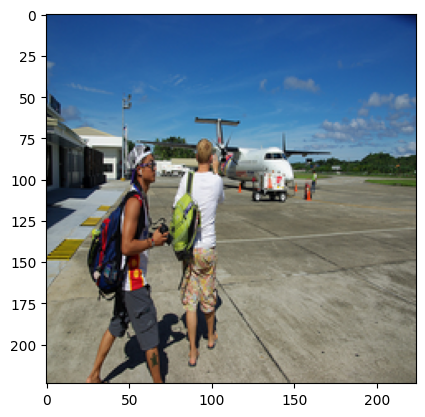

In [6]:
idx = 104
show_image(df_train.image[idx], df_train.caption[idx])

In [7]:
print(f"Training has {df_train.shape[0]} ({df_train.image.nunique()}) records and Validation Dataset has {df_valid.shape[0]}  ({df_valid.image.nunique()})")

Training has 591753 (118287) records and Validation Dataset has 25014  (5000)


## 3. Feature Extraction

Extract features from images using a pre-trained ResNet50 model.

<a id="ResNet50"></a>
### ResNet50 _Custom Model




In [8]:
# Load the ResNet50 model pre-trained on ImageNet data
image_model = ResNet50(include_top=False, weights='imagenet')
image_features_extract_model = Model(inputs=image_model.input, outputs=image_model.layers[-1].output)

2024-06-09 02:12:47.273007: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-09 02:12:47.273063: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-06-09 02:12:47.273073: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-06-09 02:12:47.273141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-09 02:12:47.273172: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Data Preprocessing function

In [9]:
# Function to preprocess image paths and extract features
def preprocess_and_extract_features(image_paths,model_name,batch_size=64,):
    def load_image_resnet(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.resnet50.preprocess_input(img)
        return img, image_path

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(load_image_resnet, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

    for img, path in tqdm(image_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            new_path_of_feature = os.path.join(os.path.dirname(path_of_feature) + f"{model_name1}_features.npy", os.path.basename(path_of_feature) + '.npy')
            os.makedirs(os.path.dirname(new_path_of_feature), exist_ok=True)
            np.save(new_path_of_feature, bf.numpy())

### Sample and Data Parameters

In [11]:
# Dataset preparation
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_of_samples=10000
model_name1="Resnet50"
#features_shape = 2048
attention_features_shape = 49

In [12]:
# Sample data and extract features
df_train_sample = df_train.sample(num_of_samples, random_state=62)
train_filenames_vectors_mini = df_train_sample.image.tolist()
preprocess_and_extract_features(train_filenames_vectors_mini,model_name1)

100%|██████████| 157/157 [00:48<00:00,  3.26it/s]


## 4. Tokenization and Dataset Preparation

Tokenize captions and prepare TensorFlow datasets for training.

In [13]:
# Tokenize captions
def tokenize_captions(captions, top_k=10000):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    tokenizer.fit_on_texts(captions)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    sequences = tokenizer.texts_to_sequences(captions)
    cap_vector = pad_sequences(sequences, padding='post')
    return tokenizer, cap_vector

In [14]:
top_k=10000
train_captions_wrapped = ['<start> ' + c + ' <end>' for c in df_train_sample.caption.tolist()]
tokenizer, cap_vector = tokenize_captions(train_captions_wrapped,top_k)
max_length = max(len(t) for t in cap_vector)

In [46]:
max_length

46

In [15]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(train_filenames_vectors_mini, cap_vector, test_size=0.15, random_state=0)

In [16]:
# Load the numpy files
def map_func(img_name, cap):
    name = img_name.decode('utf-8')
    new_name = name[0:name.rindex('/')] + f"{model_name1}_features.npy/" + name[name.rindex('/'):] + '.npy'
    img_tensor = np.load(new_name)
    return img_tensor, cap

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                      map_func, [item1, item2], [tf.float32, tf.int32]), 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 5. Model Architecture and Setup

Define the architecture of the encoder and decoder, including the attention mechanism. We also setup the optimizer and loss function here.


### Bahdanau Attention Class

In [18]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Encoder Class

In [19]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Decoder Class

In [20]:
#RNN Encoder with more GRU Layers
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, num_gru_layers=2):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru_layers = [tf.keras.layers.GRU(self.units,
                                               return_sequences=True,
                                               return_state=True,
                                               recurrent_initializer='glorot_uniform') for _ in range(num_gru_layers)]
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden[-1])

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        states = []
        for gru_layer in self.gru_layers:
            x, state = gru_layer(x)
            states.append(state)

        x = self.fc1(x)
        # Flatten the output for the Dense layer
        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, states, attention_weights

    def reset_state(self, batch_size):
        return [tf.zeros((batch_size, self.units)) for _ in self.gru_layers]

### Model Parameters

In [45]:
len(img_name_train)

8500

In [21]:
# Instantiate encoder and decoder
gru_layers = 1
embedding_dim = 256
units = 512
vocab_size = tokenizer.num_words + 1
num_steps = len(img_name_train) // BATCH_SIZE
start_epoch = 0

## 6. Training Operations

Set up the training operations including the optimizer, loss function, and training loop to manage the learning process.


### Optimizer and Loss

In [22]:
# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [24]:
def loss_function(real, pred):
    mask = tf.cast(tf.math.logical_not(tf.math.equal(real, 0)), dtype=pred.dtype)
    loss_ = loss_object(real, pred)
    loss_ *= mask
    return tf.reduce_mean(loss_)

### Tokenizer and Checkpoints

In [25]:
# Save the tokenizer
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"{current_time}_{num_of_samples}_{embedding_dim}_{units}_{vocab_size}_{max_length}_{gru_layers}"
with open(f'artifacts/tokenizer_{model_name}.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
# Setup checkpoints
checkpoint_path = f'checkpoints/bahdanau_{model_name}'
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [27]:
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [23]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size,gru_layers)

### Model Dimnesions and Layer shapes

In [28]:
loss_plot = []

for (batch, (img_tensor, target)) in enumerate(dataset):
    
    print('img_tensor, target:', img_tensor.shape, target.shape)
    
    #hidden = decoder.reset_state(batch_size=target.shape[0])
    #print('hidden:', hidden.shape)
    hidden = decoder.reset_state(batch_size=target.shape[0])
    for i, h in enumerate(hidden):
        print(f'Hidden state {i}:', h.shape)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    print('dec_input:', dec_input.shape)
    
    features = encoder(img_tensor)
    print('features', features.shape)
    

    # predictions, hidden, junk = decoder(dec_input, features, hidden)
    # print('predictions, hidden, junk:', predictions.shape, hidden.shape, junk.shape)
     
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    print('predictions:', predictions.shape)
    # Iterate over the hidden states list to print each tensor's shape
    for i, h in enumerate(hidden):
        print(f'Hidden state {i}:', h.shape)
    print('Attention weights:', attention_weights.shape)
    
    print('target[:, 1]:', target[:, 1].shape)
    loss = loss_function(target[:, 1], predictions)
    print('loss:', loss.numpy())
    
    dec_input = tf.expand_dims(target[:, 1], 1)
    print('dec_input:', dec_input.shape)
    
    break

img_tensor, target: (64, 49, 2048) (64, 46)
Hidden state 0: (64, 512)
dec_input: (64, 1)
features (64, 49, 256)
predictions: (64, 10001)
Hidden state 0: (64, 512)
Attention weights: (64, 49, 1)
target[:, 1]: (64,)
loss: 9.22839
dec_input: (64, 1)


## 7. Training Loop

The training loop iterates over the dataset, updating the model weights based on the loss gradients, and saves checkpoints periodically.

### Training function

In [29]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### Training

In [30]:
EPOCHS = 1

#### Train 1

In [31]:
%%time
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/1 [00:00<?, ?it/s]2024-06-09 02:19:25.129681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-09 02:19:26.115286: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Epoch 1 Batch 0 Loss 2.3306
Epoch 1 Batch 100 Loss 1.2936


100%|██████████| 1/1 [01:06<00:00, 66.45s/it]

Epoch 1 Loss 1.367475
Time taken for 1 epoch 66.28 sec

Checkpoint saved at checkpoints/bahdanau_2024-06-09_02-15-41_10000_256_512_10001_46_1/ckpt-1 at epoch 1
CPU times: user 1min 3s, sys: 9.99 s, total: 1min 13s
Wall time: 1min 6s


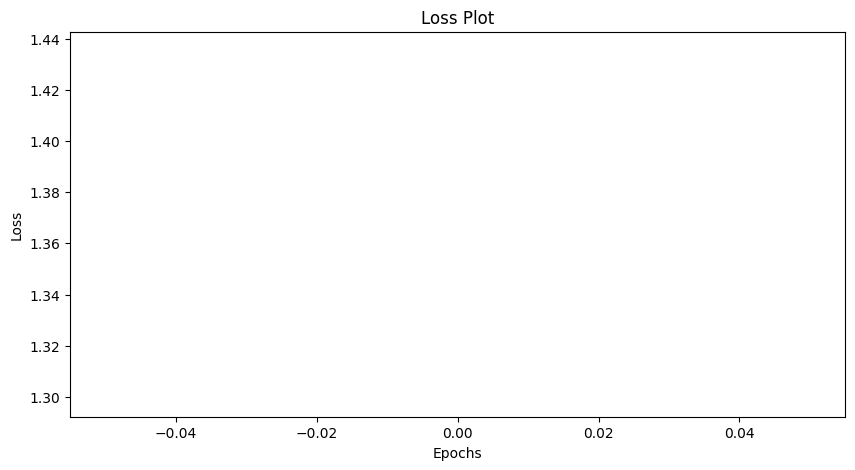

In [32]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Train 2

In [33]:
%%time
EPOCHS = 6
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 1.1908
Epoch 1 Batch 100 Loss 1.0169


 17%|█▋        | 1/6 [00:25<02:07, 25.56s/it]

Epoch 1 Loss 1.102758
Time taken for 1 epoch 25.56 sec

Epoch 2 Batch 0 Loss 1.0490
Epoch 2 Batch 100 Loss 0.9738


 33%|███▎      | 2/6 [00:50<01:40, 25.24s/it]

Epoch 2 Loss 0.975907
Time taken for 1 epoch 25.02 sec

Epoch 3 Batch 0 Loss 0.9377
Epoch 3 Batch 100 Loss 0.8418


 50%|█████     | 3/6 [01:15<01:15, 25.13s/it]

Epoch 3 Loss 0.893072
Time taken for 1 epoch 25.00 sec

Epoch 4 Batch 0 Loss 0.8553
Epoch 4 Batch 100 Loss 0.8555


 67%|██████▋   | 4/6 [01:40<00:50, 25.19s/it]

Epoch 4 Loss 0.824031
Time taken for 1 epoch 25.28 sec

Epoch 5 Batch 0 Loss 0.8915
Epoch 5 Batch 100 Loss 0.7119


 83%|████████▎ | 5/6 [02:06<00:25, 25.26s/it]

Epoch 5 Loss 0.765644
Time taken for 1 epoch 25.23 sec

Checkpoint saved at checkpoints/bahdanau_2024-06-09_02-15-41_10000_256_512_10001_46_1/ckpt-2 at epoch 5
Epoch 6 Batch 0 Loss 0.7067
Epoch 6 Batch 100 Loss 0.7269


100%|██████████| 6/6 [02:31<00:00, 25.29s/it]

Epoch 6 Loss 0.710324
Time taken for 1 epoch 25.35 sec

Checkpoint saved at checkpoints/bahdanau_2024-06-09_02-15-41_10000_256_512_10001_46_1/ckpt-3 at epoch 6
CPU times: user 2min 23s, sys: 46.9 s, total: 3min 10s
Wall time: 2min 31s


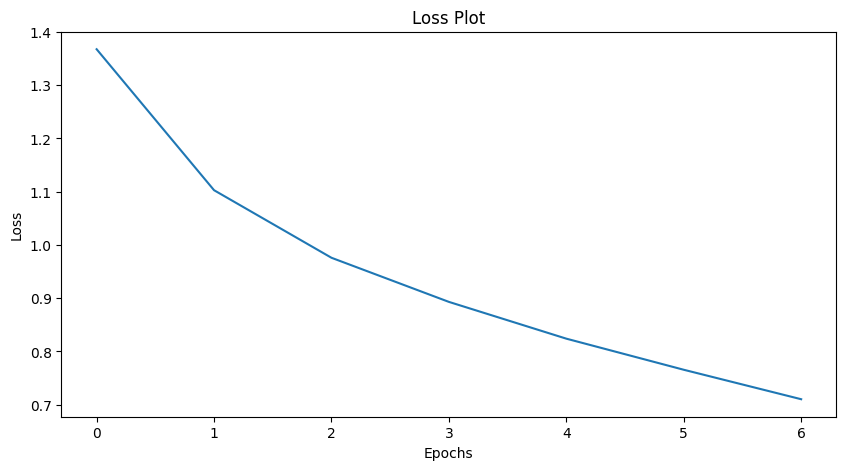

In [34]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Train 3

In [35]:
%%time
EPOCHS = 25
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.6693
Epoch 1 Batch 100 Loss 0.6697


  4%|▍         | 1/25 [00:25<10:15, 25.65s/it]

Epoch 1 Loss 0.656783
Time taken for 1 epoch 25.65 sec

Epoch 2 Batch 0 Loss 0.6581
Epoch 2 Batch 100 Loss 0.5667


  8%|▊         | 2/25 [00:50<09:43, 25.35s/it]

Epoch 2 Loss 0.603037
Time taken for 1 epoch 25.14 sec

Epoch 3 Batch 0 Loss 0.5860
Epoch 3 Batch 100 Loss 0.5319


 12%|█▏        | 3/25 [01:15<09:14, 25.22s/it]

Epoch 3 Loss 0.546942
Time taken for 1 epoch 25.07 sec

Epoch 4 Batch 0 Loss 0.5023
Epoch 4 Batch 100 Loss 0.4636


 16%|█▌        | 4/25 [01:40<08:47, 25.12s/it]

Epoch 4 Loss 0.498553
Time taken for 1 epoch 24.97 sec

Epoch 5 Batch 0 Loss 0.4711
Epoch 5 Batch 100 Loss 0.4552


 20%|██        | 5/25 [02:06<08:23, 25.18s/it]

Epoch 5 Loss 0.447385
Time taken for 1 epoch 25.14 sec

Checkpoint saved at checkpoints/bahdanau_2024-06-09_02-15-41_10000_256_512_10001_46_1/ckpt-4 at epoch 5
Epoch 6 Batch 0 Loss 0.4647
Epoch 6 Batch 100 Loss 0.4043


 24%|██▍       | 6/25 [02:32<08:04, 25.50s/it]

Epoch 6 Loss 0.399804
Time taken for 1 epoch 26.12 sec

Epoch 7 Batch 0 Loss 0.4168
Epoch 7 Batch 100 Loss 0.3549


 28%|██▊       | 7/25 [02:58<07:40, 25.59s/it]

Epoch 7 Loss 0.358084
Time taken for 1 epoch 25.76 sec

Epoch 8 Batch 0 Loss 0.3615
Epoch 8 Batch 100 Loss 0.2940


 32%|███▏      | 8/25 [03:23<07:16, 25.66s/it]

Epoch 8 Loss 0.319274
Time taken for 1 epoch 25.82 sec

Epoch 9 Batch 0 Loss 0.3315
Epoch 9 Batch 100 Loss 0.2899


 36%|███▌      | 9/25 [03:49<06:51, 25.72s/it]

Epoch 9 Loss 0.280649
Time taken for 1 epoch 25.84 sec

Epoch 10 Batch 0 Loss 0.2715
Epoch 10 Batch 100 Loss 0.2325


 40%|████      | 10/25 [04:16<06:28, 25.92s/it]

Epoch 10 Loss 0.245404
Time taken for 1 epoch 26.21 sec

Checkpoint saved at checkpoints/bahdanau_2024-06-09_02-15-41_10000_256_512_10001_46_1/ckpt-5 at epoch 10
Epoch 11 Batch 0 Loss 0.2468
Epoch 11 Batch 100 Loss 0.2253


 44%|████▍     | 11/25 [04:41<06:01, 25.81s/it]

Epoch 11 Loss 0.218248
Time taken for 1 epoch 25.55 sec

Epoch 12 Batch 0 Loss 0.2481
Epoch 12 Batch 100 Loss 0.1738


 48%|████▊     | 12/25 [05:06<05:32, 25.56s/it]

Epoch 12 Loss 0.190805
Time taken for 1 epoch 24.99 sec

Epoch 13 Batch 0 Loss 0.1984
Epoch 13 Batch 100 Loss 0.1504


 52%|█████▏    | 13/25 [05:32<05:08, 25.71s/it]

Epoch 13 Loss 0.168385
Time taken for 1 epoch 26.05 sec

Epoch 14 Batch 0 Loss 0.2049
Epoch 14 Batch 100 Loss 0.1411


 56%|█████▌    | 14/25 [05:58<04:42, 25.65s/it]

Epoch 14 Loss 0.147484
Time taken for 1 epoch 25.53 sec

Epoch 15 Batch 0 Loss 0.1611
Epoch 15 Batch 100 Loss 0.1371


 60%|██████    | 15/25 [06:23<04:14, 25.46s/it]

Epoch 15 Loss 0.131823
Time taken for 1 epoch 24.87 sec

Checkpoint saved at checkpoints/bahdanau_2024-06-09_02-15-41_10000_256_512_10001_46_1/ckpt-6 at epoch 15
Epoch 16 Batch 0 Loss 0.1533
Epoch 16 Batch 100 Loss 0.1120


 64%|██████▍   | 16/25 [06:48<03:47, 25.28s/it]

Epoch 16 Loss 0.115837
Time taken for 1 epoch 24.86 sec

Epoch 17 Batch 0 Loss 0.1356
Epoch 17 Batch 100 Loss 0.0957


 68%|██████▊   | 17/25 [07:13<03:22, 25.34s/it]

Epoch 17 Loss 0.103175
Time taken for 1 epoch 25.48 sec

Epoch 18 Batch 0 Loss 0.1234
Epoch 18 Batch 100 Loss 0.0887


 72%|███████▏  | 18/25 [07:39<02:57, 25.41s/it]

Epoch 18 Loss 0.091058
Time taken for 1 epoch 25.57 sec

Epoch 19 Batch 0 Loss 0.0932
Epoch 19 Batch 100 Loss 0.0807


 76%|███████▌  | 19/25 [08:04<02:33, 25.52s/it]

Epoch 19 Loss 0.082372
Time taken for 1 epoch 25.77 sec

Epoch 20 Batch 0 Loss 0.0800
Epoch 20 Batch 100 Loss 0.0714


 80%|████████  | 20/25 [08:30<02:08, 25.63s/it]

Epoch 20 Loss 0.076891
Time taken for 1 epoch 25.73 sec

Checkpoint saved at checkpoints/bahdanau_2024-06-09_02-15-41_10000_256_512_10001_46_1/ckpt-7 at epoch 20
Epoch 21 Batch 0 Loss 0.0712
Epoch 21 Batch 100 Loss 0.0620


 84%|████████▍ | 21/25 [08:56<01:42, 25.52s/it]

Epoch 21 Loss 0.069275
Time taken for 1 epoch 25.27 sec

Epoch 22 Batch 0 Loss 0.0801
Epoch 22 Batch 100 Loss 0.0681


 88%|████████▊ | 22/25 [09:21<01:16, 25.43s/it]

Epoch 22 Loss 0.066735
Time taken for 1 epoch 25.21 sec

Epoch 23 Batch 0 Loss 0.0749
Epoch 23 Batch 100 Loss 0.0582


 92%|█████████▏| 23/25 [09:46<00:50, 25.42s/it]

Epoch 23 Loss 0.062137
Time taken for 1 epoch 25.40 sec

Epoch 24 Batch 0 Loss 0.0862
Epoch 24 Batch 100 Loss 0.0462


 96%|█████████▌| 24/25 [10:11<00:25, 25.26s/it]

Epoch 24 Loss 0.058197
Time taken for 1 epoch 24.87 sec

Epoch 25 Batch 0 Loss 0.0745
Epoch 25 Batch 100 Loss 0.0630


100%|██████████| 25/25 [10:36<00:00, 25.46s/it]

Epoch 25 Loss 0.058164
Time taken for 1 epoch 24.77 sec

Checkpoint saved at checkpoints/bahdanau_2024-06-09_02-15-41_10000_256_512_10001_46_1/ckpt-8 at epoch 25
CPU times: user 10min 15s, sys: 3min 14s, total: 13min 30s
Wall time: 10min 36s


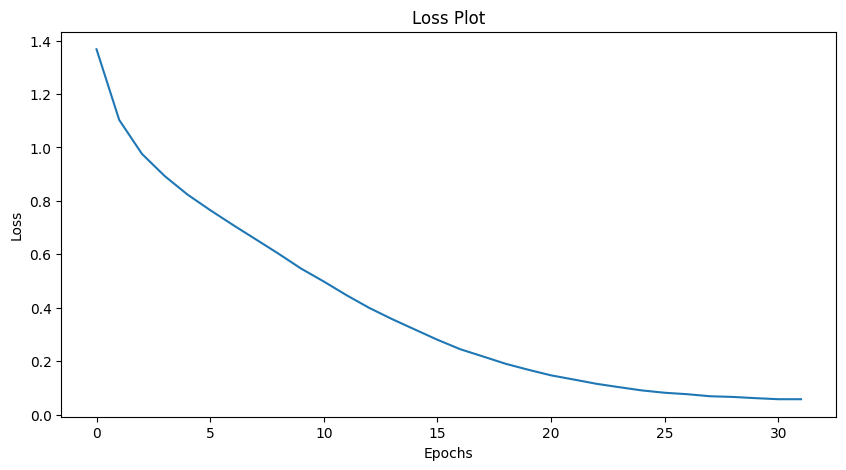

In [36]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## 8. Model Evaluation and Visualization

We provide functions to evaluate our model on new images, generate captions, and visualize attention weights to understand which parts of the image the model focuses on while generating each word in the caption.


### Inference and Attention Plotting functions

In [37]:
def evaluate(image_path):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Resetting the decoder state
    hidden = decoder.reset_state(batch_size=1)

    # Loading and processing the image
    temp_input = tf.expand_dims(load_image(image_path), 0)  # Correctly applying expand_dims
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Passing image through the encoder
    features = encoder(img_tensor_val)

    # Decoder setup
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [38]:
def evaluate_and_show(image_path):
    # Displaying the image using previously defined show_image function
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[img_id] if i not in [0]])
    real_caption = '<start> ' + real_caption + ' <end>'

    # Evaluate the image to generate caption and attention plot
    result, attention_plot = evaluate(image_path)

    prediction_caption = ' '.join(result)
    print('Real Caption:', real_caption)
    print('Prediction Caption:', prediction_caption)

    # Showing the image
    show_image(image_path, real_caption)

    # Displaying the attention plots
    plot_attention(image_path, result, attention_plot)

Real Caption: <start> <start> a herd of zebra standing next to a lush green tree <end> <end>
Prediction Caption: two ipods on three three three three three three three clocks sits on three three three three birds sit image of three three three three three three three three three three three three three three three three three three three three clocks have three three three
<start> <start> a herd of zebra standing next to a lush green tree <end> <end>


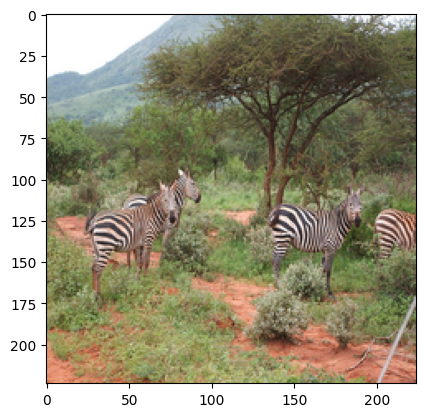

/var/folders/zw/rm73pxq9065980p1jg6sh01r0000gn/T/ipykernel_65808/2719093058.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


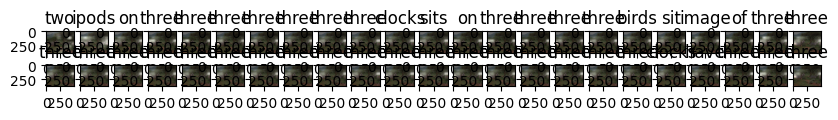

In [39]:
# Assuming img_id is an index to a specific image in the validation set
img_id = 25  # or any valid index into img_name_val
image_path = img_name_val[img_id]

# Function call
evaluate_and_show(image_path)

### Additional Functionality for Working with URLs

For handling images directly from URLs, the notebook includes utilities to download and uniquely identify images based on their URLs.


231934/231934 [==============================] - 0s 0us/step
Prediction Caption: two ipods on three several three three three birds sit image of three birds sit image of three clocks sits on the birds sit image of three three birds sit image of three three clocks sits image of three clocks sits sit image of three three


/var/folders/zw/rm73pxq9065980p1jg6sh01r0000gn/T/ipykernel_65808/2719093058.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


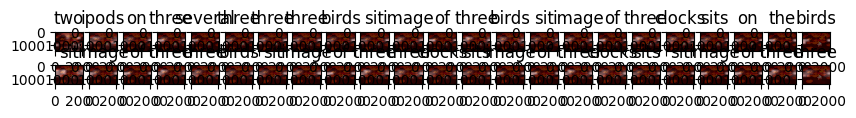

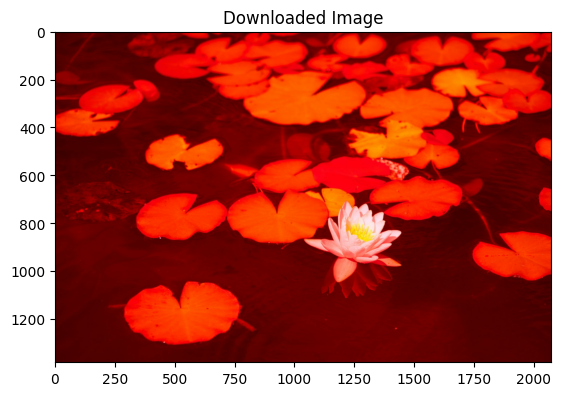

In [44]:
import hashlib

def get_unique_filename(url):
    """ Generate a unique filename based on the hash of the URL. """
    return hashlib.md5(url.encode('utf-8')).hexdigest()

image_url = 'https://images.unsplash.com/photo-1711376330637-a23fb3b495fd?q=80&w=2071&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
image_extension = get_image_extension(image_url)
unique_filename = get_unique_filename(image_url) + image_extension

# Download the image and get the local path
image_path = tf.keras.utils.get_file(unique_filename, origin=image_url)

# Evaluate the image to generate a caption and the attention plot
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))

# Plot the attention on the image
plot_attention(image_path, result, attention_plot)

# Display the downloaded image
img = Image.open(image_path)
plt.imshow(img)
plt.title('Downloaded Image')
plt.show()